# 2.4 手写数字识别之网络结构

第2.2节我们尝试使用与房价预测相同的简单神经网络解决手写数字识别问题，但是效果并不理想。原因是手写数字识别的输入是$28\times 28$的像素值，输出是0~9的数字标签，而线性回归模型无法捕捉二维图像数据中蕴含的复杂信息，如 **图1** 所示。无论是牛顿第二定律任务，还是房价预测任务，输入特征和输出预测值之间的关系均可以使用“直线”刻画（使用线性方程来表达）。但手写数字识别任务的输入像素和输出数字标签之间的关系显然不是线性的，甚至这个关系复杂到我们靠人脑难以直观理解的程度。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/959776f4cd9c4b77b380c7d29f59df1cf47be626cd8b4bd1ac1af2a7d8e3c1cf" width="800" hegiht="" ></center>
<center><br>图1：数字识别任务的输入和输出不是线性关系 </br></center>
<br></br>

因此，我们需要尝试使用其他更复杂、更强大的网络来构建手写数字识别任务，观察一下训练效果，即将“横纵式”教学法从横向展开，如 **图2** 所示。本节主要介绍两种常见的网络结构：经典的多层全连接神经网络和卷积神经网络。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/a3cec44cfb614703a12d17b3dacf5d9ef92d5a82db2046c1b5f8aba744bb80de" width="1200" hegiht="" ></center>
<center><br>图2：“横纵式”教学法 — 网络结构优化 </br></center>
<br></br>


**数据处理**

数据处理已在前面内容中介绍，这里直接调用封装好的函数即可：

In [1]:
from data_process import get_MNIST_dataloader

train_loader,_ = get_MNIST_dataloader()

e:\SoftWare\Program\Anaconda\envs\d2l\lib\site-packages\paddle\fluid\reader.py:486: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


## 2.4.1 经典的全连接神经网络

神经元是构成神经网络的基本单元，其基本结构如 **图3** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/a3a10a9bb0f34ed4b95faa41ce04b88da0ae68e2bb14483bbf967bfc5acdd54b" width="500" hegiht="" ></center>
<center><br>图3：神经元结构</br></center>
<br></br>

神经元输入为向量$\boldsymbol{x}=[x_1;...;x_D]$，净输入$z \in R$表示神经元输入的加权和，公式如下：

$$
z = \sum^D_{d=1}w_dx_d+b,
$$

其中$\boldsymbol{w}=[w_1;...;w_D] \in R^D$为权重向量，$b \in R$是偏置。

然后净输入$z$经过激活函数$f(.)$得到该神经元的活性值$a \in R$：
$$
a = f(z).
$$

经典的全连接神经网络来包含四层网络：输入层、两个隐含层和输出层，将手写数字识别任务通过全连接神经网络表示，如 **图4** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/2173259df0704335b230ec158be0427677b9c77fd42348a28f2f8adf1ac1c706" width="600" hegiht="" ></center>
<center><br>图4：手写数字识别任务的全连接神经网络结构</br></center>
<br></br>

* 输入层：将数据输入给神经网络。在该任务中，输入层的尺度为28×28的像素值。
* 隐含层：增加网络深度和复杂度，隐含层的节点数是可以调整的，节点数越多，神经网络表示能力越强，参数量也会增加。在该任务中，中间的两个隐含层为10×10的结构，通常隐含层会比输入层的尺寸小，以便对关键信息做抽象，激活函数使用常见的Sigmoid函数。
* 输出层：输出网络计算结果，输出层的节点数是固定的。如果是回归问题，节点数量为需要回归的数字数量。如果是分类问题，则是分类标签的数量。在该任务中，模型的输出是回归一个数字，输出层的尺寸为1。

------
**说明：**

隐含层引入非线性激活函数Sigmoid是为了增加神经网络的非线性能力。

举例来说，如果一个神经网络采用线性变换，有四个输入$x_1$~$x_4$，一个输出$y$。假设第一层的变换是$z_1=x_1-x_2$和$z_2=x_3+x_4$，第二层的变换是$y=z_1+z_2$，则将两层的变换展开后得到$y=x_1-x_2+x_3+x_4$。也就是说，无论中间累积了多少层线性变换，原始输入和最终输出之间依然是线性关系。
 
------


Sigmoid是早期神经网络模型中常见的非线性变换函数，公式为

$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$

通过如下代码，绘制出Sigmoid的函数曲线。

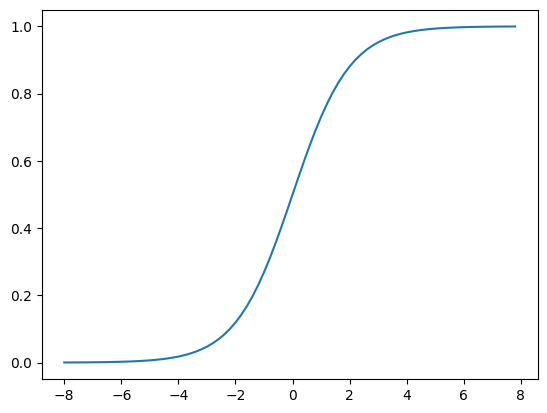

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    # 直接返回sigmoid函数
    return 1. / (1. + np.exp(-x))
 
# param:起点，终点，间距
x = np.arange(-8, 8, 0.2)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

针对手写数字识别的任务，网络层的设计如下：

* 输入层的尺度为$28\times 28$，但批次计算的时候会统一加1个维度（大小为batch size）。
* 中间的两个隐含层为$10\times 10$的结构，激活函数使用Sigmoid函数。
* 与房价预测模型一样，模型的输出是回归一个数字，输出层的尺寸设置成1。

下述代码为经典全连接神经网络的实现。完成网络结构定义后，即可训练神经网络。

------

**说明：**  
数据迭代器train_loader在每次迭代时的数据shape为[batch_size, 1, 28, 28]，因此需要将该数据形式改变为向量形式。

In [3]:
import paddle
import paddle.nn.functional as F
from paddle.nn import Linear

# 定义多层全连接神经网络
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 定义两层全连接隐含层，输出维度是10，当前设定隐含节点数为10，可根据任务调整
        self.fc1 = Linear(in_features=784, out_features=10)
        self.fc2 = Linear(in_features=10, out_features=10)
        # 定义一层全连接输出层，输出维度是1
        self.fc3 = Linear(in_features=10, out_features=1)
    
    # 定义网络的前向计算，隐含层激活函数为sigmoid，输出层不使用激活函数
    def forward(self, inputs):
        inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.sigmoid(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.sigmoid(outputs2)
        outputs_final = self.fc3(outputs2)
        return outputs_final

[paddle.summary(net, input_size, dtypes=None)](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/summary_cn.html#summary)函数能够打印网络的基础结构和参数信息。

> paddle.summary(net, input_size=None, dtypes=None, input=None)

关键参数含义如下：

* net (Layer) - 网络实例，必须是 Layer 的子类。
* input_size (tuple|InputSpec|list[tuple|InputSpec) - 输入张量的大小。如果网络只有一个输入，那么该值需要设定为tuple或InputSpec。如果模型有多个输入。那么该值需要设定为list[tuple|InputSpec]，包含每个输入的shape。
* dtypes (str，可选) - 输入张量的数据类型，如果没有给定，默认使用 float32 类型。默认值：None

返回：字典，包含了总的参数量和总的可训练的参数量。

下面我们打印上面定义的全连接神经网络基础结构和参数信息：

In [4]:
model = MNIST()
params_info = paddle.summary(model, (1, 1, 28, 28))
print(params_info)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-1          [[1, 784]]            [1, 10]             7,850     
   Linear-2          [[1, 10]]             [1, 10]              110      
   Linear-3          [[1, 10]]              [1, 1]              11       
Total params: 7,971
Trainable params: 7,971
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
---------------------------------------------------------------------------

{'total_params': 7971, 'trainable_params': 7971}


使用MNIST数据集训练定义好的经典全连接神经网络。


In [5]:
#网络结构部分之后的代码，保持不变
def train(model):
    model.train()
    
    # 使用SGD优化器，learning_rate设置为0.01
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # 训练5轮
    EPOCH_NUM = 10

    loss_list = []
    
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data

            images = paddle.to_tensor(images)

            labels = paddle.to_tensor(labels, dtype="float32")
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                loss_list.append(avg_loss.numpy()[0])
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    return loss_list

model = MNIST()
loss_list = train(model)

epoch: 0, batch: 0, loss is: [22.682804]
epoch: 0, batch: 200, loss is: [4.3640976]
epoch: 0, batch: 400, loss is: [3.5816107]
epoch: 0, batch: 600, loss is: [3.0418255]
epoch: 0, batch: 800, loss is: [3.1924312]
epoch: 1, batch: 0, loss is: [3.5587363]
epoch: 1, batch: 200, loss is: [2.5361586]
epoch: 1, batch: 400, loss is: [1.8444169]
epoch: 1, batch: 600, loss is: [2.7607617]
epoch: 1, batch: 800, loss is: [2.3482409]
epoch: 2, batch: 0, loss is: [1.647733]
epoch: 2, batch: 200, loss is: [1.861239]
epoch: 2, batch: 400, loss is: [1.5835242]
epoch: 2, batch: 600, loss is: [1.618321]
epoch: 2, batch: 800, loss is: [0.9619008]
epoch: 3, batch: 0, loss is: [0.9487031]
epoch: 3, batch: 200, loss is: [0.8131092]
epoch: 3, batch: 400, loss is: [1.9850992]
epoch: 3, batch: 600, loss is: [1.2607346]
epoch: 3, batch: 800, loss is: [1.0952826]
epoch: 4, batch: 0, loss is: [0.9702466]
epoch: 4, batch: 200, loss is: [1.4157552]
epoch: 4, batch: 400, loss is: [0.73892254]
epoch: 4, batch: 600, l

根据损失函数变化情况绘制曲线：

In [6]:
from tools import plot

plot(loss_list)

ModuleNotFoundError: No module named 'tools'

## 2.4.2 卷积神经网络

虽然使用经典的全连接神经网络可以提升一定的准确率，但其输入数据的形式导致丢失了图像像素间的空间信息，这影响了网络对图像内容的理解。对于计算机视觉问题，效果最好的模型仍然是卷积神经网络。卷积神经网络针对视觉问题的特点进行了网络结构优化，可以直接处理原始形式的图像数据，保留像素间的空间信息，因此更适合处理视觉问题。

卷积神经网络由多个卷积层和池化层组成，如 **图5** 所示。卷积层负责对输入进行扫描以生成更抽象的特征表示，池化层对这些特征表示进行过滤，保留最关键的特征信息。
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/b4defbe432e349029eedaed3343bb988fec1a353a7ea4eeba7b9b1930b25f26b" width="800" hegiht="" ></center>
<center><br>图5：在处理计算机视觉任务中大放异彩的卷积神经网络</br></center>
<br></br>


-------
**说明：**

本节只简单介绍用卷积神经网络实现手写数字识别任务，以及它带来的效果提升。读者可以将卷积神经网络先简单的理解成是一种比经典的全连接神经网络更强大的模型即可，更详细的原理和实现在接下来的《计算机视觉-卷积神经网络基础》中讲述。

------

两层卷积和池化的神经网络实现如下所示。

> 注：本实现与**图5**不同，如本实现输出长度为1。

In [ ]:
# 定义 SimpleNet 网络结构
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是1
         self.fc = Linear(in_features=980, out_features=1)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层不使用激活函数
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], -1])
         x = self.fc(x)
         return x

打印网络结构：

In [ ]:
model = MNIST()
params_info = paddle.summary(model, (1, 1, 28, 28))
print(params_info)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 1, 28, 28]]     [1, 20, 28, 28]          520      
  MaxPool2D-1    [[1, 20, 28, 28]]     [1, 20, 14, 14]           0       
   Conv2D-2      [[1, 20, 14, 14]]     [1, 20, 14, 14]        10,020     
  MaxPool2D-2    [[1, 20, 14, 14]]      [1, 20, 7, 7]            0       
   Linear-10         [[1, 980]]             [1, 1]              981      
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.04
Estimated Total Size (MB): 0.23
---------------------------------------------------------------------------

{'total_params': 11521, 'trainable_params': 11521}



使用MNIST数据集训练定义好的卷积神经网络，如下所示。  


In [ ]:
#网络结构部分之后的代码，保持不变
def train(model):
    model.train()
    
    learning_rate = 0.001 

    # 使用SGD优化器，设置learning_rate
    opt = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())
    # 训练5轮
    EPOCH_NUM = 10
    # MNIST图像高和宽
    IMG_ROWS, IMG_COLS = 28, 28

    loss_list = []

    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels, dtype="float32")
            
            #前向计算的过程
            predicts = model(images) # [batch_size, 1]

            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                loss_list.append(avg_loss.numpy()[0])
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')

    return loss_list

model = MNIST()
loss_list_conv = train(model)

epoch: 0, batch: 0, loss is: [33.812702]
epoch: 0, batch: 200, loss is: [2.4981875]
epoch: 0, batch: 400, loss is: [2.748225]
epoch: 0, batch: 600, loss is: [2.2872992]
epoch: 0, batch: 800, loss is: [2.0726104]
epoch: 1, batch: 0, loss is: [1.7020338]
epoch: 1, batch: 200, loss is: [2.6824403]
epoch: 1, batch: 400, loss is: [1.6056092]
epoch: 1, batch: 600, loss is: [1.59251]
epoch: 1, batch: 800, loss is: [1.869786]
epoch: 2, batch: 0, loss is: [2.965779]
epoch: 2, batch: 200, loss is: [1.7460155]
epoch: 2, batch: 400, loss is: [1.9291373]
epoch: 2, batch: 600, loss is: [1.5594203]
epoch: 2, batch: 800, loss is: [1.7343291]
epoch: 3, batch: 0, loss is: [1.6700295]
epoch: 3, batch: 200, loss is: [1.686054]
epoch: 3, batch: 400, loss is: [1.0776438]
epoch: 3, batch: 600, loss is: [1.785841]
epoch: 3, batch: 800, loss is: [1.9272344]
epoch: 4, batch: 0, loss is: [1.8695885]
epoch: 4, batch: 200, loss is: [1.0488331]
epoch: 4, batch: 400, loss is: [1.5479116]
epoch: 4, batch: 600, loss i

同时绘制两个网络结构训练时损失函数变化曲线：

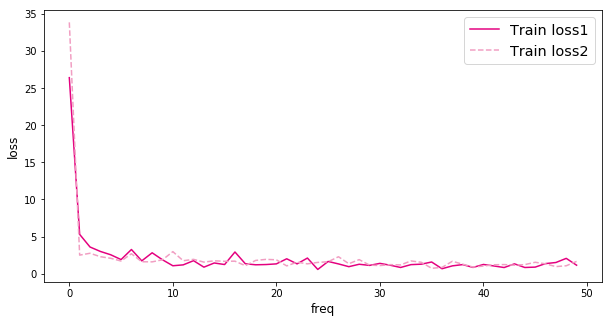

In [ ]:
def plot_two_losses(loss_list_1, loss_list_2):
    plt.figure(figsize=(10,5))
    
    freqs = [i for i in range(len(loss_list_1))]

    # 绘制训练损失变化曲线
    plt.plot(freqs, loss_list_1, color='#e4007f', label="Train loss1")
    plt.plot(freqs, loss_list_2, color='#f19ec2', linestyle='--', label="Train loss2")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("freq", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

plot_two_losses(loss_list, loss_list_conv)

从损失函数变化趋势看，全连接神经网络和卷积神经网络收敛速度相当。目前我们的卷积神经网络做的是一个回归任务，接下来我们尝试将回归任务替换成分类任务，看看卷积神经网络效果如何。